<a href="https://colab.research.google.com/github/russell-ai/SOTA/blob/main/blip_itm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'BLIP' already exists and is not an empty directory.
/content/BLIP


### zero-shot image-text classification

In [6]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

In [8]:
image_size = 384
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

In [7]:
urls = [
    "https://media.istockphoto.com/photos/gorgeous-african-black-children-portrait-smiling-and-laughing-picture-id909126464?k=20&m=909126464&s=170667a&w=0&h=9j7215FAtGWJVu7cVo4AXleR6T07QIxAck9VavHGLis=",
    "http://im.rediff.com/sports/2014/may/25fans4.jpg", # Emotion
    "https://cutewallpaper.org/24/images-of-sad-people/you%E2%80%A6with-the-sad-eyes-you-are-beautiful-by-barri-sambaris-write--medium.jpeg",
    "https://m.media-amazon.com/images/I/615Kr5gtGhL._SL1500_.jpg", # inventory
    "https://5.imimg.com/data5/RM/FM/MY-67226295/mens-brown-formal-leather-shoes-500x500.jpg",
    "https://i4.hurimg.com/i/hurriyet/75/866x494/632777c84e3fe1167045b304.jpg", # Brand
    "https://www.theglobeandmail.com/resizer/9IqQqyTnsmIsZVChXReUKeO78ZQ=/600x0/filters:quality(80):format(jpeg)/cloudfront-us-east-1.images.arcpublishing.com/tgam/2XCT3JN7ZRGMNAFSMZM2RSTH2I.jpeg",
    "https://ichef.bbci.co.uk/food/ic/food_16x9_832/recipes/rib-eye_steak_with_61963_16x9.jpg" # Food 
    ]

In [13]:
# ground-truths are 4th. one in each list.
captions = [
            ["unhappy", "sad", "neutral", "joyful"],
            ["happy", "angry", "excited", "worried", "sad"],
            ["negative", "positive", "joyful", "sad"],
            ["projector", "computer","screen", "printer", "calculator", "X-Box", "cartridge"],
            ["sport shoes", "walking shoe", "heeled shoes", "patent leather shoes", "boot"],
            ["mercedes", "audio","bmw", "toyota", "honda", "alfa romeo", "chevrolet"],
            ["Volkswagen", "Toyota", "audio", "Honda", "mercedes"],
            ["Salad", "Sandwich","Bread", "Steak", "Tuna Steak", "Fish", "Shrimp", "Rice"]
        ]

In [9]:
def load_demo_image(image_size,device, img_url):
    img_url = img_url
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

## coco-base

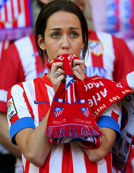

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0050, 0.0460, 0.0700, 0.0460, 0.0330], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.0980, 0.1980, 0.2210, 0.1920, 0.1760]], grad_fn=<RoundBackward1>)


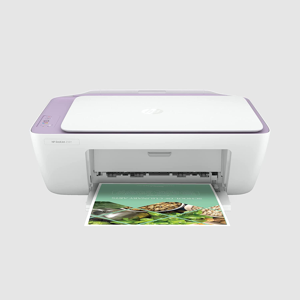

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0150, 0.0120, 0.0640, 0.7500, 0.0020, 0.0150, 0.0380],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2920, 0.3440, 0.2830, 0.4260, 0.2110, 0.1480, 0.2430]],
       grad_fn=<RoundBackward1>)


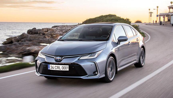

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.6570, 0.0000, 0.0000, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2560, 0.1810, 0.2440, 0.3600, 0.2670, 0.2580, 0.3070]],
       grad_fn=<RoundBackward1>)


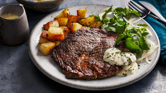

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.6610, 0.0010, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2010, 0.2020, 0.1960, 0.3710, 0.2950, 0.1180, 0.1030, 0.1070]],
       grad_fn=<RoundBackward1>)


In [ ]:
from models.blip_itm import blip_itm

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
    model.eval()
    model = model.to(device='cpu')
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

**clip's results**

In [ ]:
# openai/clip-vit-large-patch14-336 prediction scores:

array([[0.003, 0.066, 0.02 , 0.901, 0.01 ]], dtype=float32)
array([[0.001, 0.   , 0.   , 0.998, 0.   , 0.   , 0.001]], dtype=float32)
array([[0.001, 0.001, 0.   , 0.995, 0.002, 0.   , 0.001]], dtype=float32)
array([[0.001, 0.   , 0.   , 0.994, 0.005, 0.   , 0.   , 0.   ]], dtype=float32)

## large-coco

In [ ]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth'

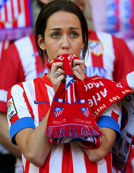

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0840, 0.1410, 0.4380, 0.2110, 0.2060], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.0630, 0.1680, 0.1720, 0.1830, 0.1340]], grad_fn=<RoundBackward1>)


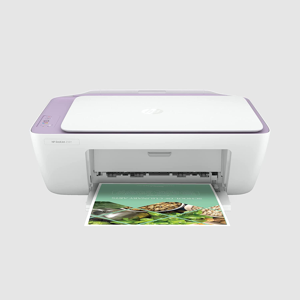

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0060, 0.1210, 0.0470, 0.8320, 0.0000, 0.0030, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2450, 0.2370, 0.1940, 0.3750, 0.1920, 0.1700, 0.2190]],
       grad_fn=<RoundBackward1>)


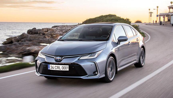

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0010, 0.0010, 0.5020, 0.0010, 0.0000, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2390, 0.1570, 0.2340, 0.3690, 0.2100, 0.2340, 0.2360]],
       grad_fn=<RoundBackward1>)


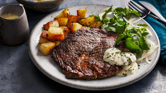

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.2150, 0.0010, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.1490, 0.1130, 0.0890, 0.3400, 0.3170, 0.1250, 0.0580, 0.1160]],
       grad_fn=<RoundBackward1>)


In [ ]:
from models.blip_itm import blip_itm

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_itm(pretrained=model_url, image_size=image_size, vit='large')
    model.eval()
    model = model.to(device='cpu')
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

## large-flickr

In [9]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_flickr.pth'

  0%|          | 0.00/3.43G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_flickr.pth


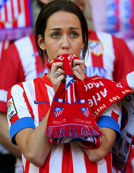

text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0320, 0.1080, 0.1230, 0.1780, 0.1270], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2330, 0.2800, 0.2780, 0.2880, 0.2370]], grad_fn=<RoundBackward1>)


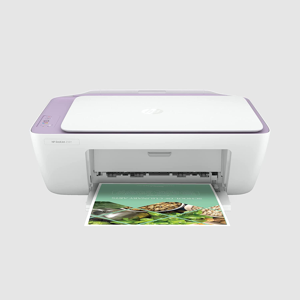

text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0060, 0.0940, 0.0120, 0.9120, 0.0000, 0.0060, 0.0020],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3410, 0.3540, 0.3160, 0.4770, 0.2900, 0.2740, 0.3040]],
       grad_fn=<RoundBackward1>)


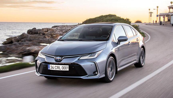

text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0010, 0.0010, 0.7640, 0.0010, 0.0010, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3200, 0.2580, 0.3130, 0.4570, 0.2980, 0.3100, 0.3210]],
       grad_fn=<RoundBackward1>)


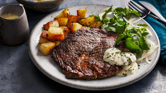

text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.4710, 0.0080, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2290, 0.1880, 0.1790, 0.4340, 0.3910, 0.2390, 0.1920, 0.2160]],
       grad_fn=<RoundBackward1>)


In [ ]:
from models.blip_itm import blip_itm

model = blip_itm(pretrained=model_url, image_size=image_size, vit='large')
model.eval()
model = model.to(device='cpu')

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

### 2

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_flickr.pth


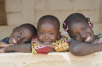

text: ['unhappy', 'sad', 'neutral', 'joyful']
probability-itm-score: tensor([0.0130, 0.0070, 0.0490, 0.0500], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2150, 0.2180, 0.1640, 0.2540]], grad_fn=<RoundBackward1>)


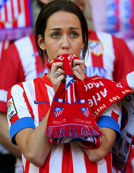

text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0320, 0.1080, 0.1230, 0.1780, 0.1270], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2330, 0.2800, 0.2780, 0.2880, 0.2370]], grad_fn=<RoundBackward1>)


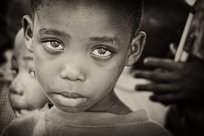

text: ['negative', 'positive', 'joyful', 'sad']
probability-itm-score: tensor([0.1360, 0.0710, 0.0290, 0.3990], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2680, 0.2520, 0.2370, 0.3240]], grad_fn=<RoundBackward1>)


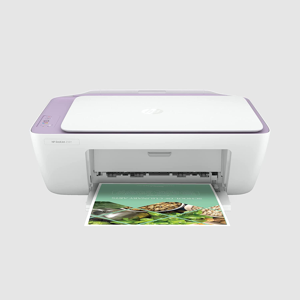

text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0060, 0.0940, 0.0120, 0.9120, 0.0000, 0.0060, 0.0020],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3410, 0.3540, 0.3160, 0.4770, 0.2900, 0.2740, 0.3040]],
       grad_fn=<RoundBackward1>)


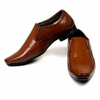

text: ['sport shoes', 'walking shoe', 'heeled shoes', 'patent leather shoes', 'boot']
probability-itm-score: tensor([0.0010, 0.0040, 0.0840, 0.5170, 0.0010], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2710, 0.2620, 0.3310, 0.4180, 0.2240]], grad_fn=<RoundBackward1>)


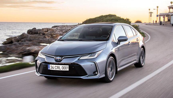

text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0010, 0.0010, 0.7640, 0.0010, 0.0010, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3200, 0.2580, 0.3130, 0.4570, 0.2980, 0.3100, 0.3210]],
       grad_fn=<RoundBackward1>)


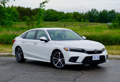

text: ['Volkswagen', 'Toyota', 'audio', 'Honda', 'mercedes']
probability-itm-score: tensor([0.3870, 0.0800, 0.0010, 0.4300, 0.0000], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.4030, 0.3830, 0.2310, 0.3790, 0.3000]], grad_fn=<RoundBackward1>)


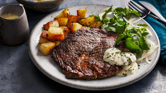

text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.4710, 0.0080, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2290, 0.1880, 0.1790, 0.4340, 0.3910, 0.2390, 0.1920, 0.2160]],
       grad_fn=<RoundBackward1>)


In [14]:
from models.blip_itm import blip_itm

model = blip_itm(pretrained=model_url, image_size=image_size, vit='large')
model.eval()
model = model.to(device='cpu')

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

# Image Captioning
Perform image captioning using finetuned BLIP model

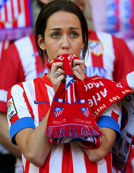

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a atletico fan


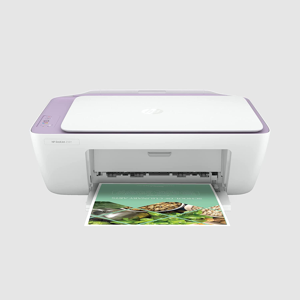

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: the hp desk printer


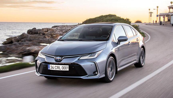

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: the toyota coroll on the road


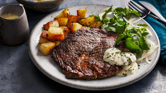

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a steak steak with potatoes and herbs on a plate


In [ ]:
from models.blip import blip_decoder
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'


for img_url in urls:
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        print('caption: '+caption[0])
        print("=="*100)

### 2

  0%|          | 0.00/1.66G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth


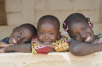

caption: a group of young children posing for a picture


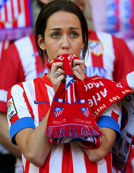

caption: a woman holding a scarf in front of her face


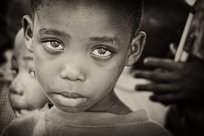

caption: a young boy is looking at the camera


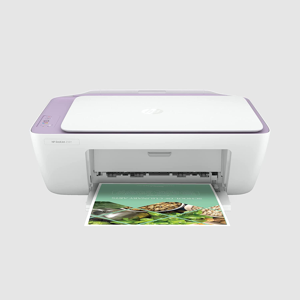

caption: a printer with a picture of a bird on it


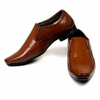

caption: a pair of brown shoes on a white surface


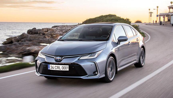

caption: a silver toyota corollant driving down a road next to the ocean


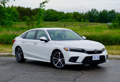

caption: a white car parked on the side of the road


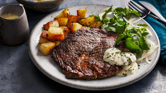

caption: a plate of steak with potatoes and a side salad


In [15]:
from models.blip import blip_decoder
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'


model = blip_decoder(pretrained=model_url, image_size=image_size, vit='large')
model.eval()
model = model.to(device)

for img_url in urls:
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)


    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        print('caption: '+caption[0])
        print("=="*100)

### 3

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


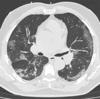

caption: a ct scan


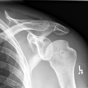

caption: the chest with a radiograph of the chest and a radiograph of the chest


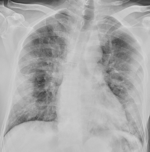

caption: the chest and chest


In [11]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

urls = [
        "https://pubs.rsna.org/cms/10.1148/rg.2020200159/asset/images/medium/rg.2020200159.fig7a.gif",
        "https://prod-images-static.radiopaedia.org/images/133745/b195ce6926c4ec406b8dcb33ded4c1_gallery.jpg",
        "https://tidsskriftet.no/sites/default/files/styles/default_scale/public/article--2020--04--20-0332--KRO_20-0332-02_ENG.jpg?itok=FW7MParN"
        ]
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

for img_url in urls:
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)


    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        print('caption: '+caption[0])
        print("=="*100)

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth


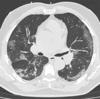

caption: a ct scan of a person's lungs


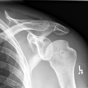

caption: a black and white photo of a human shoulder


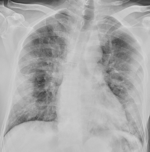

caption: an x - ray image of a chest and lungs


In [13]:
from models.blip import blip_decoder
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'


urls = [
        "https://pubs.rsna.org/cms/10.1148/rg.2020200159/asset/images/medium/rg.2020200159.fig7a.gif",
        "https://prod-images-static.radiopaedia.org/images/133745/b195ce6926c4ec406b8dcb33ded4c1_gallery.jpg",
        "https://tidsskriftet.no/sites/default/files/styles/default_scale/public/article--2020--04--20-0332--KRO_20-0332-02_ENG.jpg?itok=FW7MParN"
        ]

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='large')
model.eval()
model = model.to(device)

for img_url in urls:
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)


    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        print('caption: '+caption[0])
        print("=="*100)